In [173]:
import jax
import tax
import clu
import optax
import rlax
import tqdm
import chex
import tree
import typing
import functools
import haiku as hk
import numpy as np
import collections 
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt

import mbrl
from jax import jit
from jax import vmap
from jax import grad
from jax import value_and_grad
from functools import partial

from jax.experimental.optimizers import clip_grads
from jax.experimental.optimizers import l2_norm
from mbrl.envs.oracle.pendulum import render, step, reset, env_params
from mbrl.algs.rs import trajectory_search, forecast, score, plan
from mbrl.common.nn import mlp_deterministic

from scipy.signal import savgol_filter

smooth = functools.partial(savgol_filter, window_length=51, polyorder=3)

Environment = collections.namedtuple('Environment', ['step', 'reset'])

# Initialization.
rng = jax.random.PRNGKey(42)
env = Environment(
    jit(lambda state, u: step(env_params, state, u)), 
    jit(reset)
)

In [174]:
def world(carry, t):
    keys, (env_state, observation), trajectory = carry
    action = trajectory[t]
    env_state_next, observation_next, reward, terminal, info = \
        env.step(env_state, action)
    carry = keys, (env_state_next, observation_next), trajectory
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 'env_state_next': env_state_next
    }

In [175]:
score_    = jit(partial(score, terminal_reward_fn = None, discount = 0.99))
forecast_ = jit(partial(
    forecast, 
    step_fn=world, 
    horizon=20, 
    action_dim=1, 
    minval=-2., 
    maxval=2.))

In [176]:
""" Entire Loop with scan"""

def one_step(carry, t):
    key, (env_state, observation)  = carry
    key, subkey = jax.random.split(key)
    action = plan(subkey, (env_state, observation), forecast_, score_)[0][0]
    env_state_next, observation_next, reward, terminal, info = \
        env.step(env_state, action)
    carry = key, (env_state_next, observation_next)
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 'env_state_next': env_state_next
    }

In [232]:
# Build Value Function
vf_def = mlp_deterministic(1, [64, 64], activation='silu', final_tanh_activation=False)
vf_def = hk.transform(vf_def)
vf_def = hk.without_apply_rng(vf_def)
vf_params = vf_def.init(rng, jnp.zeros((3,)))
vf_opt = optax.adabelief(learning_rate=1e-3)
vf_opt_state = vf_opt.init(vf_params)
vf_def = vf_def.apply

@chex.dataclass
class State:
    params: typing.Any
    opt_state: typing.Any
        
state = State(params=vf_params, opt_state=vf_opt_state)

# NOTE: This approach would need a target `value_target_params`.
@jax.partial(jit, static_argnums=(2,))
def loss_value_td0(value_params, batch: dict, value_def):
    chex.assert_rank([batch['reward'], batch['discount']], 1)
    vf_t = value_def(value_params, batch['observation'])
    vf_tp1 = value_def(value_params, batch['observation_next'])
    vf_tp1 = jax.lax.stop_gradient(vf_tp1)
    target = batch['reward'] + batch['discount'] * vf_tp1
    chex.assert_equal_shape([target, vf_t])
    loss = rlax.l2_loss(vf_t, target)
    return loss

@jax.partial(jit, static_argnums=(2,))
def loss_value_MC(value_params, batch: dict, value_def):
    chex.assert_rank([batch['returns']], 1)
    vf_t = value_def(value_params, batch['observation'])
    target = batch['returns']
    chex.assert_equal_shape([target, vf_t])
    loss = rlax.l2_loss(vf_t, target)
    return loss

@jax.partial(jit, static_argnums=(2, 3))
def update(state, batch, loss, optimizer, clip_gradient_norm: float = 5.0):
    l, g = value_and_grad(loss)(state.params, batch)
    if clip_gradient_norm > 0.0:
        g = clip_grads(g, clip_gradient_norm)
    u, opt_state = optimizer.update(g, state.opt_state)
    p = optax.apply_updates(state.params, u)
    state = state.replace(params=p, opt_state=opt_state)
    return state, {'loss': l, 'grad_l2norm': l2_norm(g)}

loss_ = jit(lambda p, b: vmap(jax.partial(loss_value_MC, value_def=vf_def), (None, 0))(p, b).mean())
update_ = jit(jax.partial(update, loss=loss_, optimizer=vf_opt))

rb = tax.ReplayBuffer(100_000)

In [233]:
# Loop. Training -> Data -> Fit -> Value

In [245]:
def make_value_inference(p):
    return jit(lambda x: vf_def(p, x))

In [254]:
value_inference = make_value_inference(state.params)
score_    = jit(partial(score, terminal_reward_fn = value_inference, discount = 0.99))
forecast_ = jit(partial(
    forecast, 
    step_fn=world, 
    horizon=20, 
    action_dim=1, 
    minval=-2., 
    maxval=2.)
)

def one_step(carry, t):
    key, (env_state, observation)  = carry
    key, subkey = jax.random.split(key)
    action = plan(subkey, (env_state, observation), forecast_, score_)[0][0]
    env_state_next, observation_next, reward, terminal, info = \
        env.step(env_state, action)
    carry = key, (env_state_next, observation_next)
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 'env_state_next': env_state_next
    }


data = []
all_score = []
for _ in tqdm.notebook.trange(100):
    rng, subrng = jax.random.split(rng)
    env_state, observation = env.reset(subrng)
    init = (rng, (env_state, observation))
    _, out = jax.lax.scan(one_step, init, jnp.arange(200))
    out.update({'returns': tax.discounted_return(out['reward'], 0.99)})
    all_score.append(jnp.sum(out['reward']))
    data.append(out)
all_score = jnp.stack(all_score)
score_mean = float(all_score.mean())
score_std = float(all_score.std())

print(f'mean: {score_mean}')
print(f'std: {score_std}')

data = tax.reduce(data, jnp.concatenate)

rb.add(**data)

print(f'Replay size: {len(rb)}')

  0%|          | 0/100 [00:00<?, ?it/s]

mean: -216.74085998535156
std: 146.21780395507812
Replay size: 80000


In [265]:
all_metrics = []
for _ in tqdm.notebook.trange(10_000):
    batch = rb.sample(64)
    batch['discount'] = batch['terminal'][..., None] * 0.99
    batch['reward'] = batch['reward'][..., None]
    batch['returns'] = batch['returns'][..., None]

    state, metrics = update_(state, batch)
    all_metrics.append(metrics)


  0%|          | 0/10900 [00:00<?, ?it/s]

In [266]:
all_metrics = tax.reduce(all_metrics, np.stack)

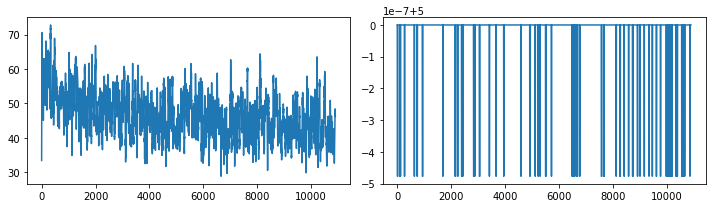

In [267]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axes[0].plot(smooth(all_metrics['loss']))
axes[1].plot(smooth(all_metrics['grad_l2norm']))
fig.tight_layout()
